In [52]:
import arviz as az
import pandas as pd
import pymc as pm
from matplotlib import rcParams, pyplot as plt

rcParams['figure.figsize'] = [12, 8]
rcParams['figure.dpi'] = 200

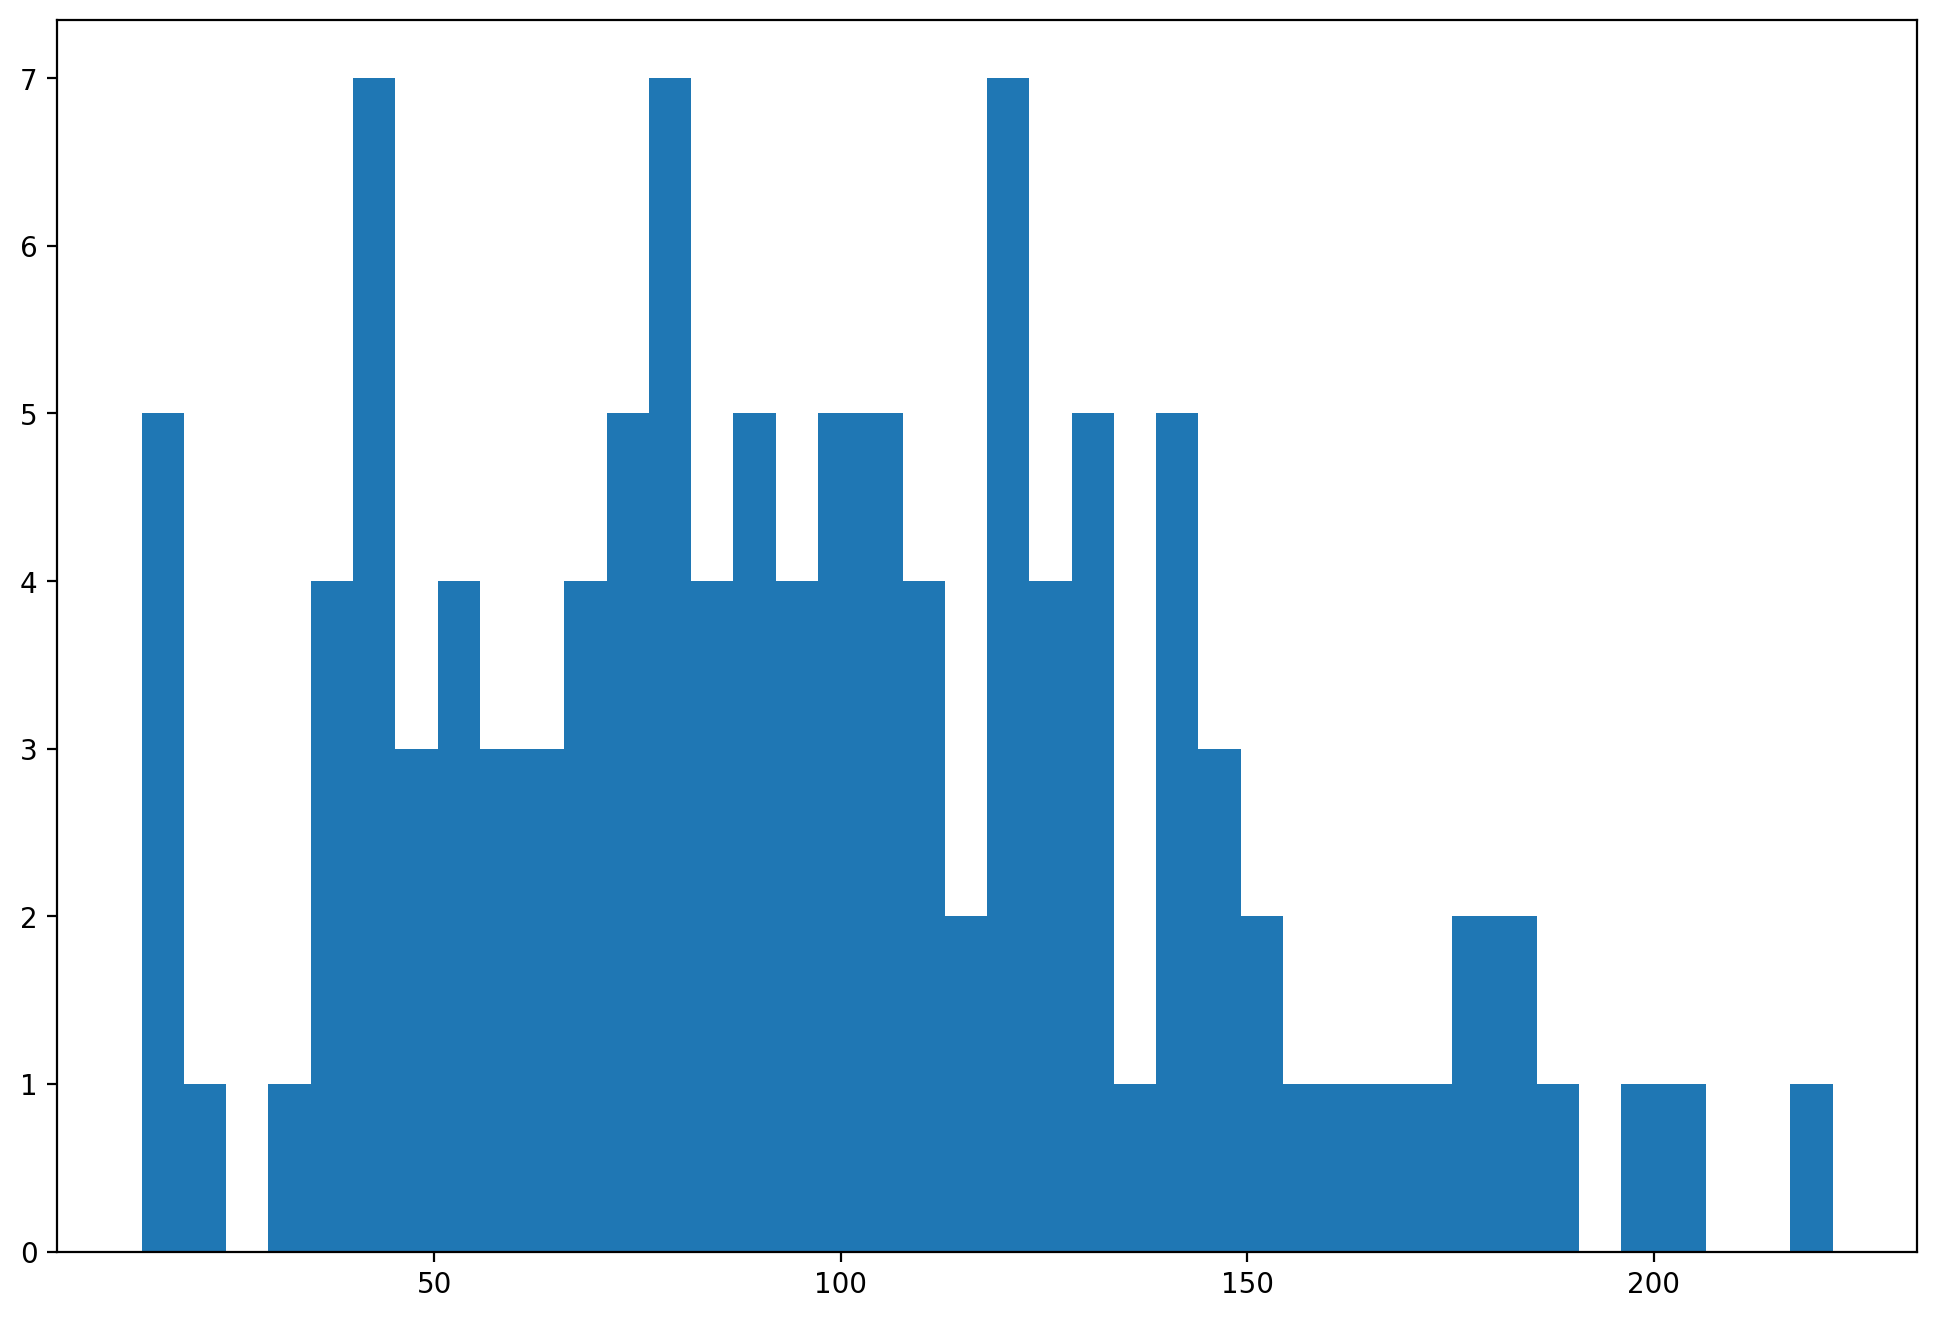

In [53]:
df = pd.read_csv('data/h1weekly.csv',
                 parse_dates=['Date'],
                 index_col='Date',
                 dtype={'IsCanceled': float})
df.index.freq = 'W-SUN'
_ = plt.hist(df, bins=40)

In [54]:
print(df.describe())

       IsCanceled
count  115.000000
mean    96.713043
std     45.865510
min     14.000000
25%     64.000000
50%     95.000000
75%    127.500000
max    222.000000


In [55]:
mu_prior=120
sigma_prior=10

with pm.Model() as model:
    mu = pm.Normal("mu", mu=mu_prior, sigma=sigma_prior)
    sd = pm.HalfNormal("sd", sigma=sigma_prior) # Half of normal, also uses sigma prior
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=df['IsCanceled'])
    idata = pm.sample(10000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sd]
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
<frozen importlib._bootstrap>:24

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 9 seconds.


In [56]:
with model:
    post_pred = pm.sample_posterior_predictive(idata.posterior)

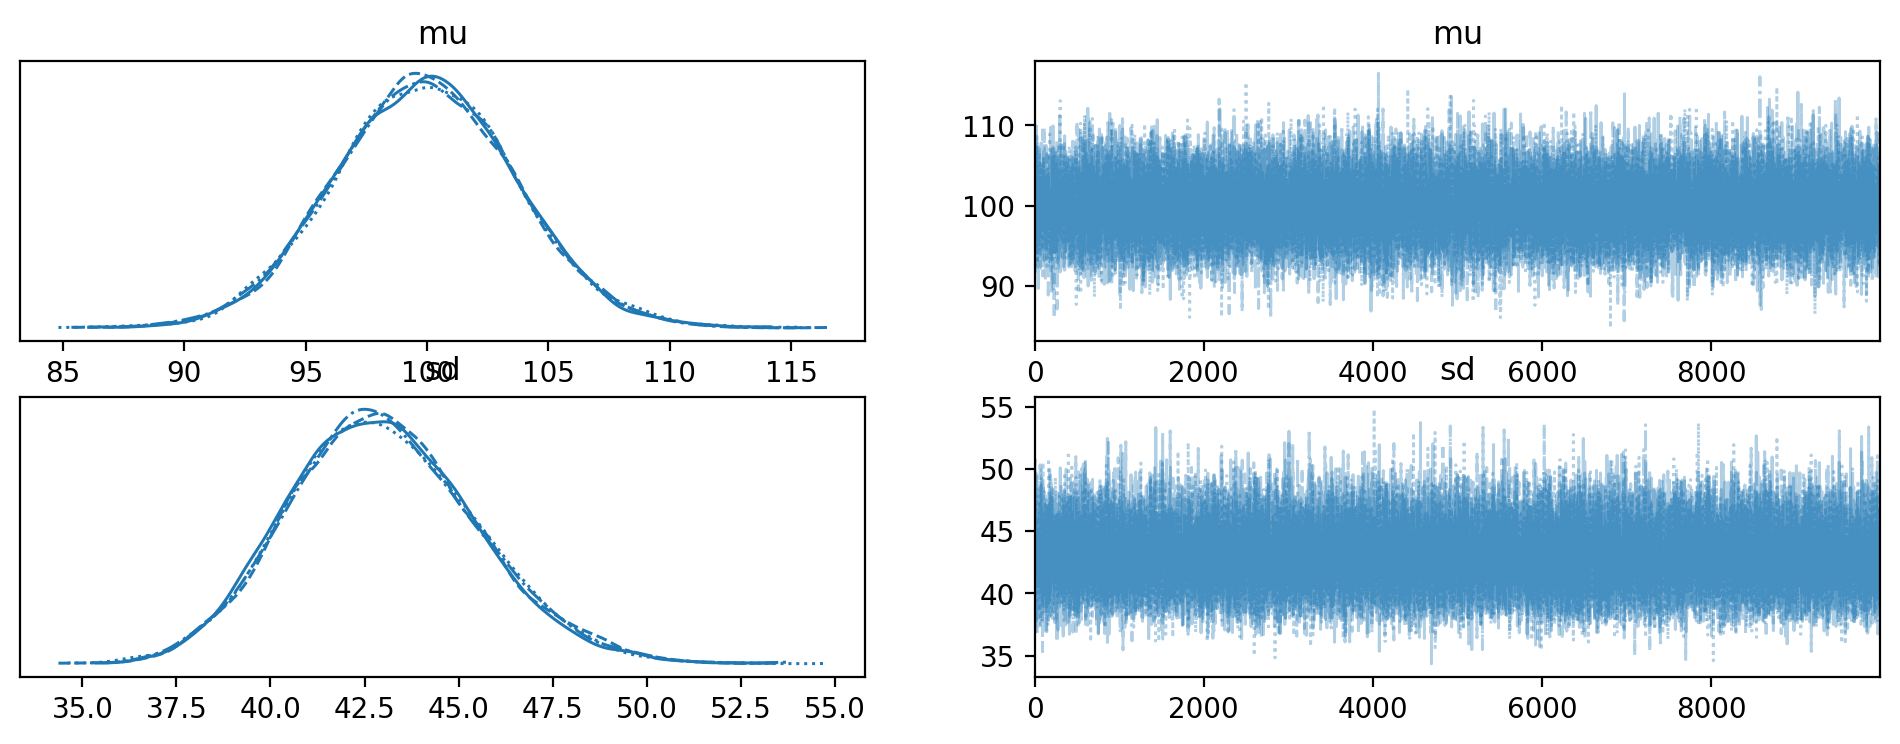

In [57]:
post_pred_az = az.from_dict(posterior_predictive=post_pred.to_dict())
az.concat([idata, post_pred_az], inplace=True)
az.plot_trace(idata);

In [58]:
print(az.summary(idata))

      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail   
mu  99.902  3.720  92.797  106.754      0.019    0.013   38192.0   28270.0  \
sd  42.993  2.499  38.287   47.673      0.013    0.009   39609.0   29980.0   

    r_hat  
mu    1.0  
sd    1.0  


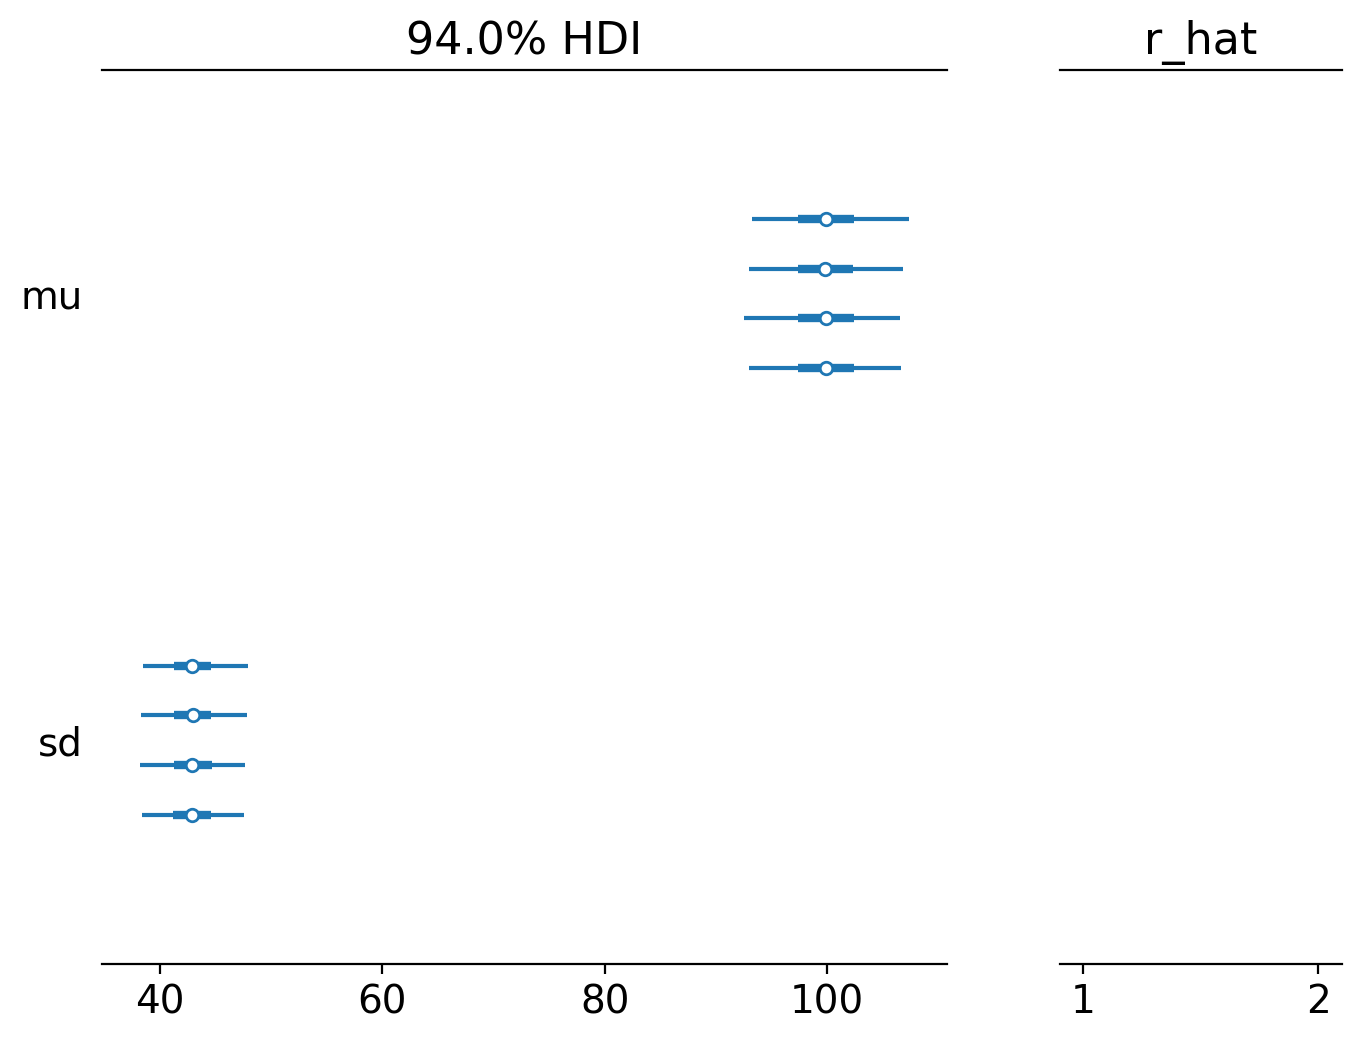

In [59]:
az.plot_forest(idata, r_hat=True);

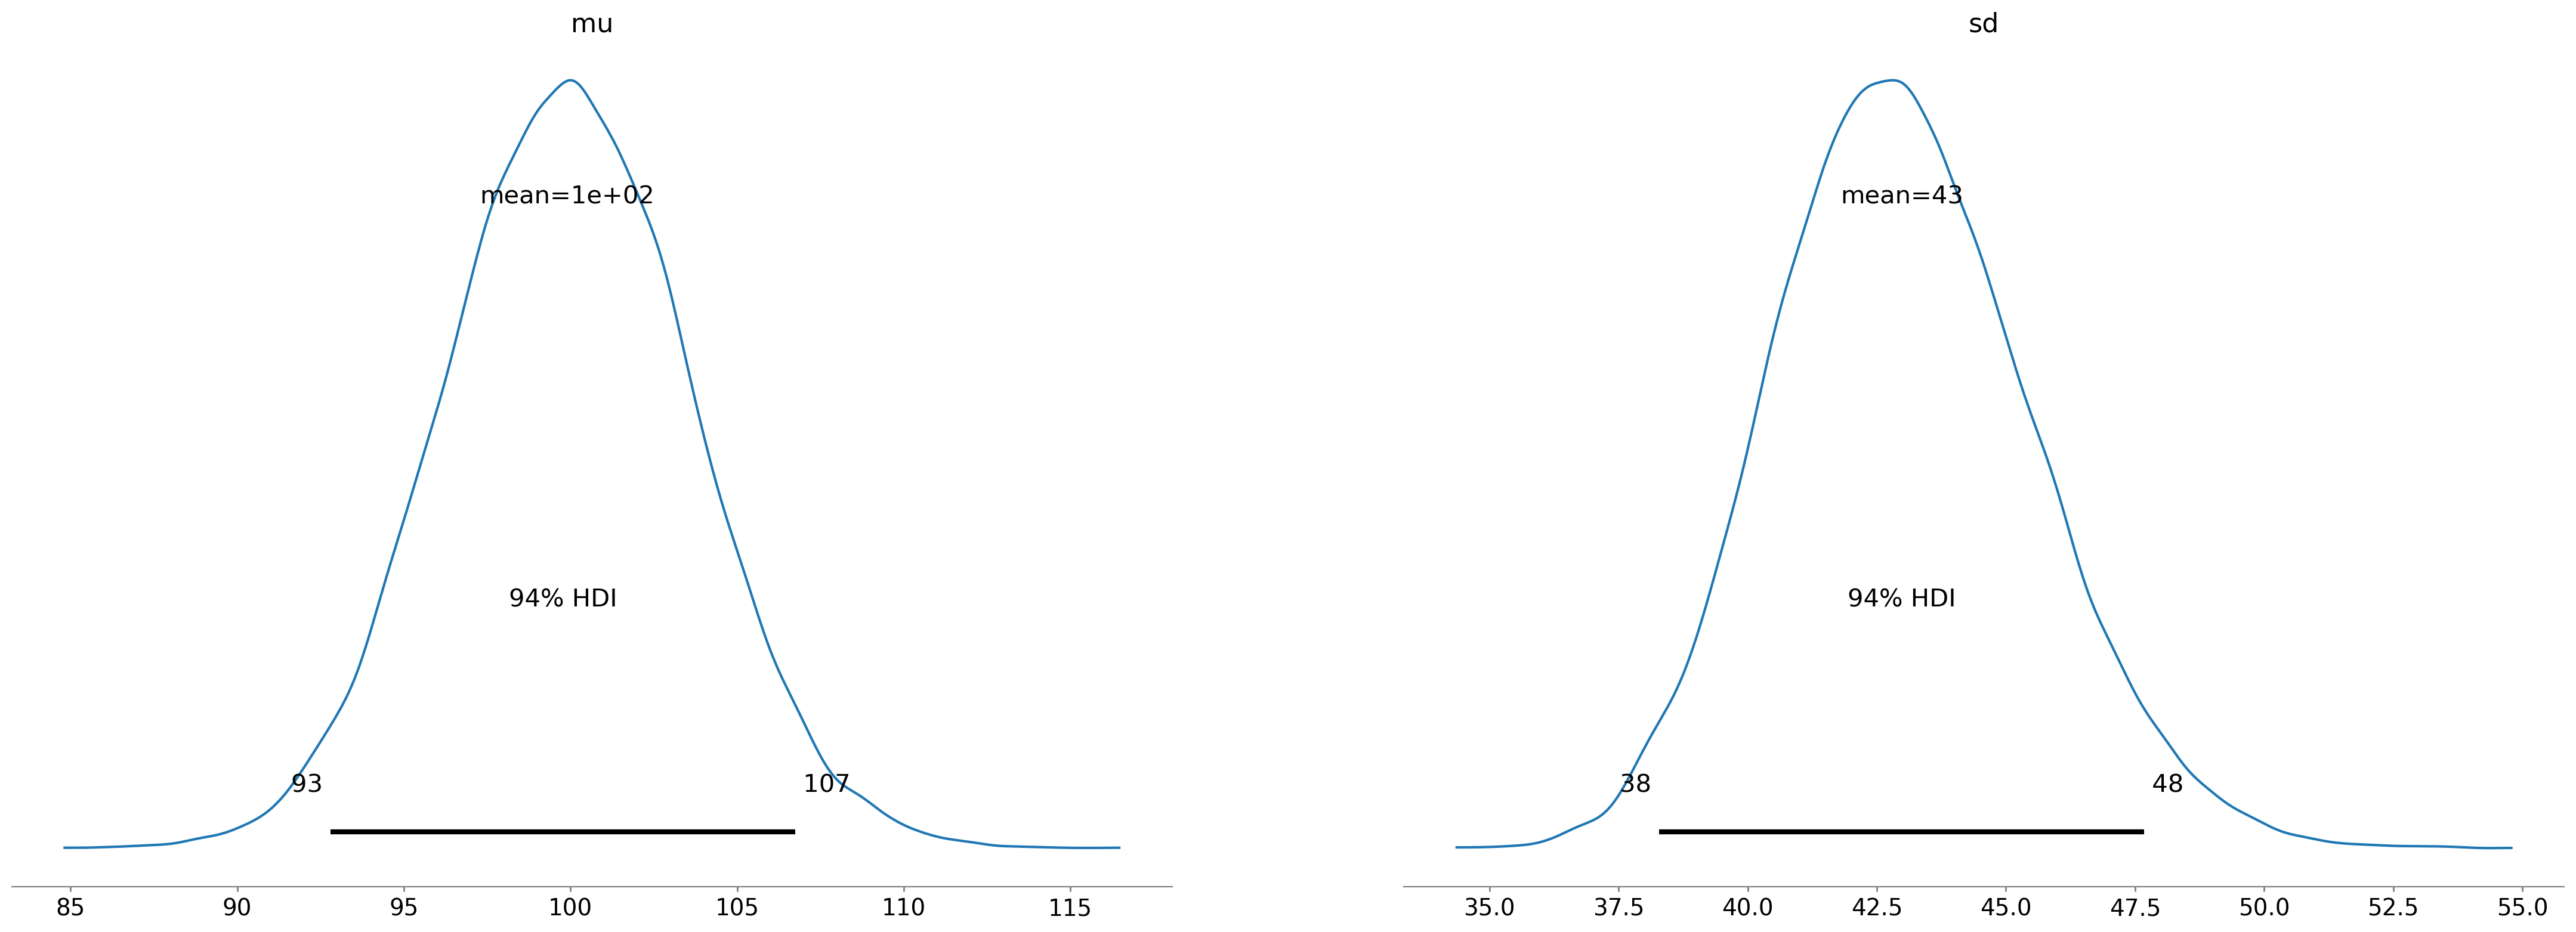

In [60]:
az.plot_posterior(idata);

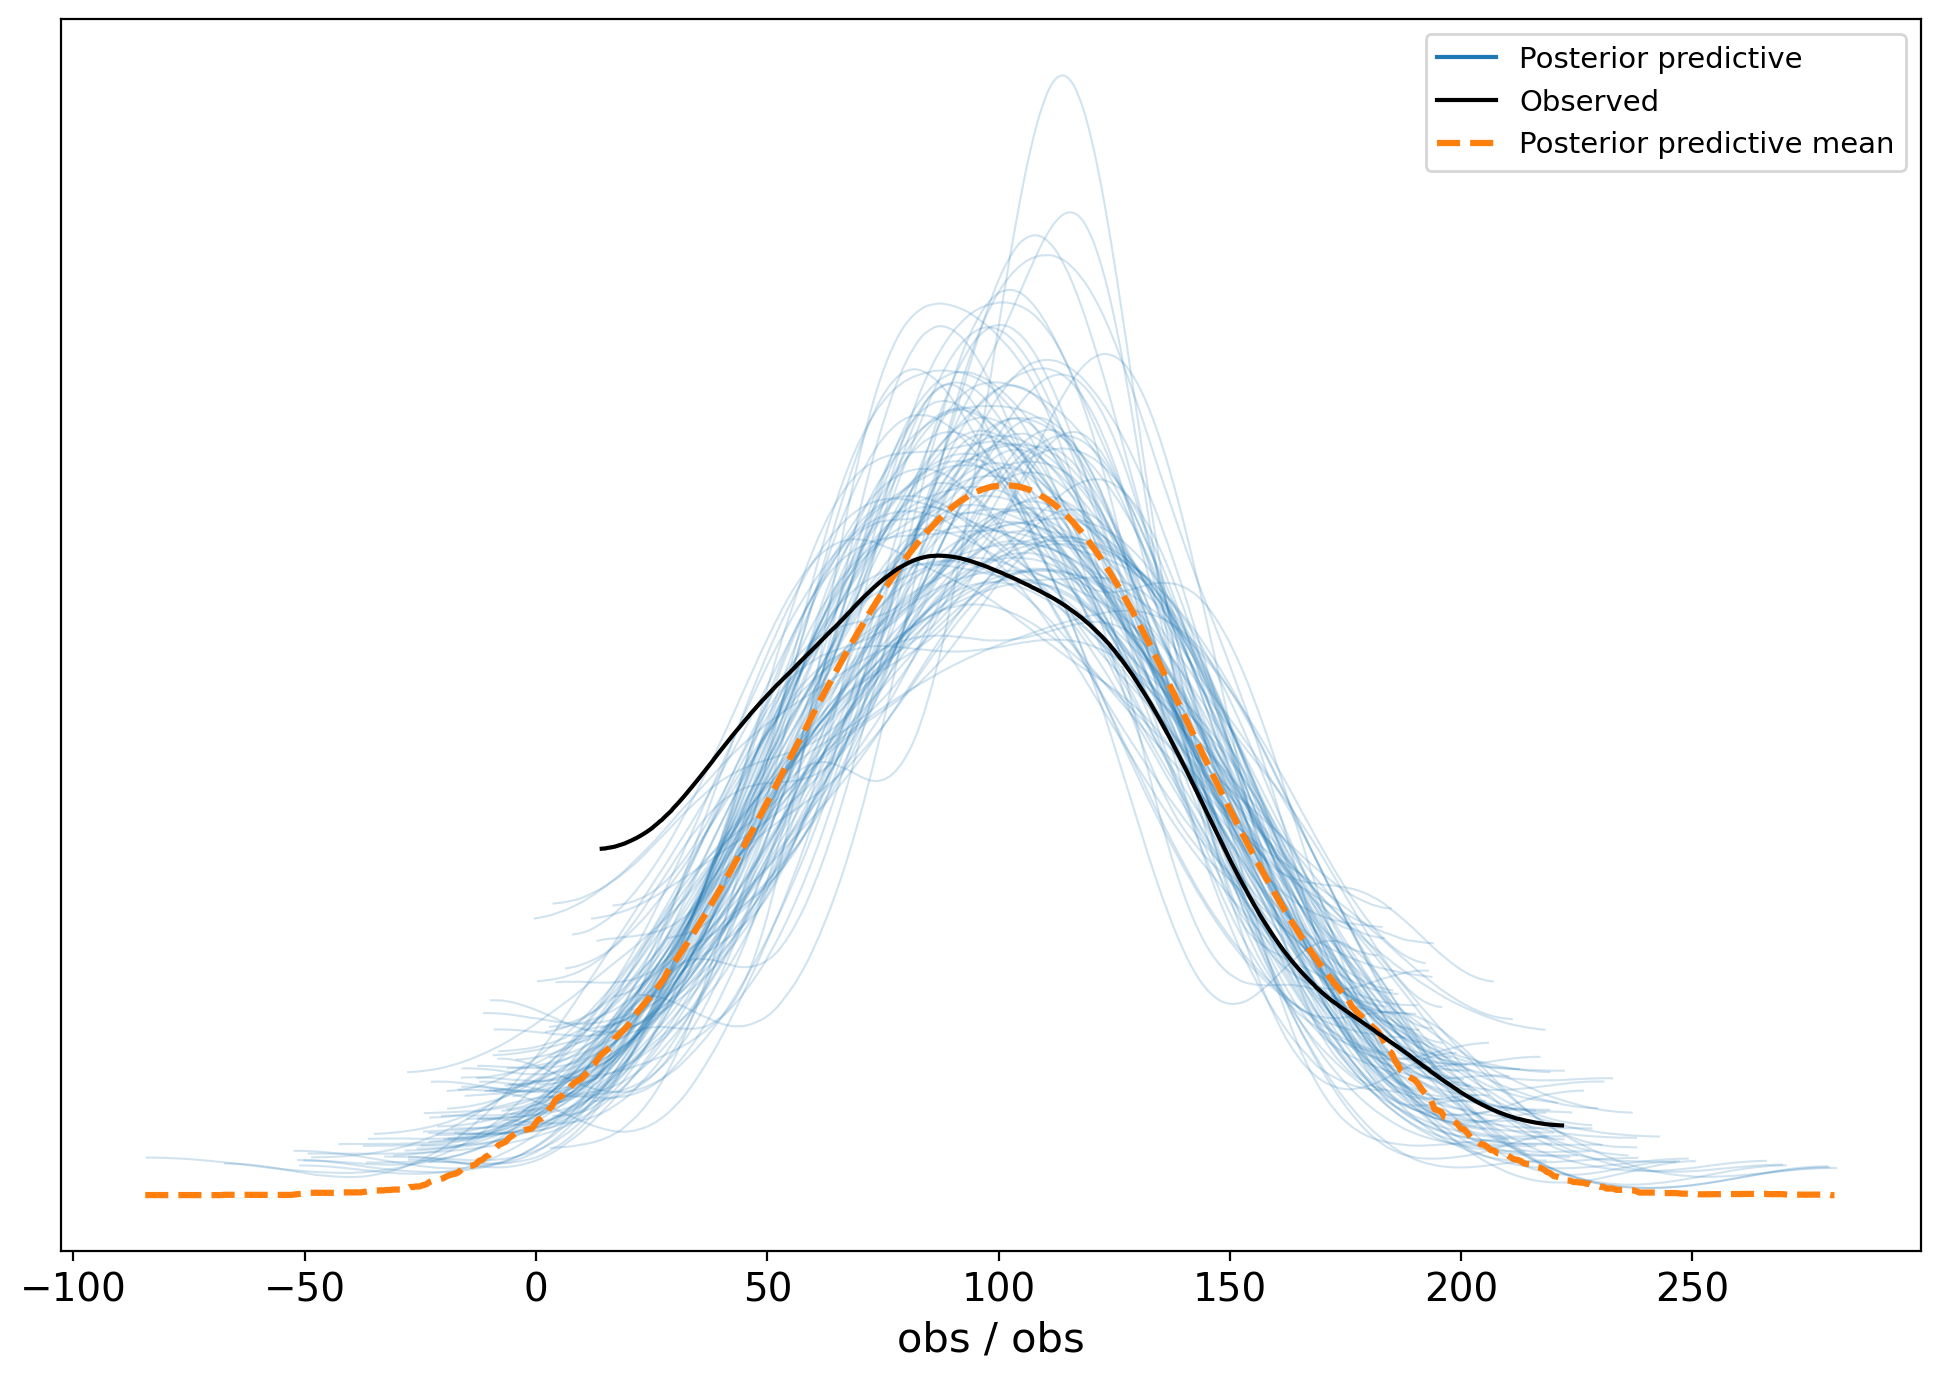

In [61]:
_ = az.plot_ppc(post_pred, num_pp_samples=100)